In [8]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical

# 1. 데이터 로드
df = pd.read_csv('smpled_wafer_10percent.csv')

# 2. waferMap 전처리 함수
def process_wafer_map(wafer_map_str):
    try:
        arr = np.array(ast.literal_eval(wafer_map_str), dtype=np.float32)
        if arr.ndim == 2:
            arr = arr.reshape(28, 28, 1)
        elif arr.ndim == 3 and arr.shape[-1] != 1:
            arr = arr[:, :, np.newaxis]
        return arr
    except Exception:
        return np.zeros((28, 28, 1), dtype=np.float32)

# 3. 필요한 컬럼만 추출하고 결측치 제거
df = df[['waferMap', 'failureType_clean']].dropna()
df['waferMap_array'] = df['waferMap'].apply(process_wafer_map)
df = df[df['waferMap_array'].apply(lambda x: isinstance(x, np.ndarray) and x.shape == (28, 28, 1))]

# 4. X, y 준비
X = df['waferMap_array']
y = pd.factorize(df['failureType_clean'])[0]  # 정수 인코딩

# 5. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 6. CNN 입력용 배열 생성
X_train_cnn_np = np.stack(X_train.values)
X_test_cnn_np = np.stack(X_test.values)

# 7. CNN 모델 정의
cnn_model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 이진 분류
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 8. CNN 학습
cnn_model.fit(X_train_cnn_np, y_train, epochs=10, batch_size=32, verbose=1)

# 9. CNN 예측
base_preds_1 = cnn_model.predict(X_train_cnn_np).flatten()

# 10. XGBoost / RF용 평탄화
X_train_flat = X_train_cnn_np.reshape(len(X_train_cnn_np), -1)

# 11. XGBoost 학습
xgb_model = XGBClassifier()
xgb_model.fit(X_train_flat, y_train)
base_preds_2 = xgb_model.predict_proba(X_train_flat)[:, 1]

# 12. RandomForest 학습
rf_model = RandomForestClassifier()
rf_model.fit(X_train_flat, y_train)
base_preds_3 = rf_model.predict_proba(X_train_flat)[:, 1]

# 13. 스태킹용 메타 입력 생성
stacked_train = np.vstack([base_preds_1, base_preds_2, base_preds_3]).T

# 14. 메타 모델 학습 (XGBoost)
meta_model = XGBClassifier()
meta_model.fit(stacked_train, y_train)

# 15. 테스트셋 처리
X_test_flat = X_test_cnn_np.reshape(len(X_test_cnn_np), -1)
test_preds_1 = cnn_model.predict(X_test_cnn_np).flatten()
test_preds_2 = xgb_model.predict_proba(X_test_flat)[:, 1]
test_preds_3 = rf_model.predict_proba(X_test_flat)[:, 1]
stacked_test = np.vstack([test_preds_1, test_preds_2, test_preds_3]).T

# 16. 최종 예측 및 평가
final_preds = meta_model.predict(stacked_test)

print("Accuracy:", accuracy_score(y_test, final_preds))
print("F1 Score:", f1_score(y_test, final_preds, average='macro'))
print("Precision:", precision_score(y_test, final_preds, average='macro'))
print("Recall:", recall_score(y_test, final_preds, average='macro'))


Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8499 - loss: 0.6930
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8522 - loss: 0.6923
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8485 - loss: 0.6930
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8550 - loss: 0.6905
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8501 - loss: 0.6934
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8531 - loss: 0.6922
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8540 - loss: 0.6917
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8518 - loss: 0.6926
Epoch 9/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8507 - loss: 0.6922
Epoch 10/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8546 - loss: 0.6916
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
Accuracy: 0.852558542931483
F1 Score: 0.1022679983354

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
import pandas as pd
import numpy as np
import cv2
import ast
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# 1. 데이터 불러오기
df = pd.read_csv('smpled_wafer_10percent.csv')

# 2. waferMap 문자열을 리스트로 변환
def parse_wafer_map(wafer_map_str):
    wafer_map_str = wafer_map_str.replace('][', '],[')
    wafer_map_str = wafer_map_str.replace(' ', ',')
    wafer_map_str = wafer_map_str.strip()
    try:
        return ast.literal_eval(wafer_map_str)
    except:
        return None

df['waferMap'] = df['waferMap'].apply(parse_wafer_map)

# 3. 잘못된 waferMap 제거
def is_valid_2d_array(wmap):
    if isinstance(wmap, list):
        if all(isinstance(row, list) for row in wmap):
            row_lens = [len(row) for row in wmap]
            return len(set(row_lens)) == 1
    return False

df = df[df['waferMap'].notna()]
df = df[df['waferMap'].apply(is_valid_2d_array)]

# 4. 결측 클래스 제거
df = df[df['failureType_clean'].notna()]

# 5. waferMap 28x28로 리사이징
def resize_map(wmap, size=(28, 28)):
    arr = np.array(wmap)
    return cv2.resize(arr, size, interpolation=cv2.INTER_NEAREST)

df['resized_map'] = df['waferMap'].apply(resize_map)

# 6. 입력/출력 데이터 준비
X = np.stack(df['resized_map'].values)
X = X.reshape(-1, 28, 28, 1).astype('float32')
y = df['failureType_clean'].values

# 7. 라벨 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

# 8. 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 9. 원-핫 인코딩
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes)

# 10. CNN 모델 정의
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 11. 모델 학습
model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_split=0.1)

# 12. 예측 및 평가
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8933 - loss: 0.5957 - val_accuracy: 0.9205 - val_loss: 0.5285
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9099 - loss: 0.4644 - val_accuracy: 0.9492 - val_loss: 0.2861
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9414 - loss: 0.3022 - val_accuracy: 0.9492 - val_loss: 0.2745
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9456 - loss: 0.2489 - val_accuracy: 0.9509 - val_loss: 0.2423
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9432 - loss: 0.2372 - val_accuracy: 0.9425 - val_loss: 0.3792
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9421 - loss: 0.2539 - val_accuracy: 0.9577 - val_loss: 0.2313
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9389 - loss: 0.2655 - val_accuracy: 0.9543 - val_loss: 0.1988
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9548 - loss: 0.1710 - val_accuracy: 0.9543 - val_

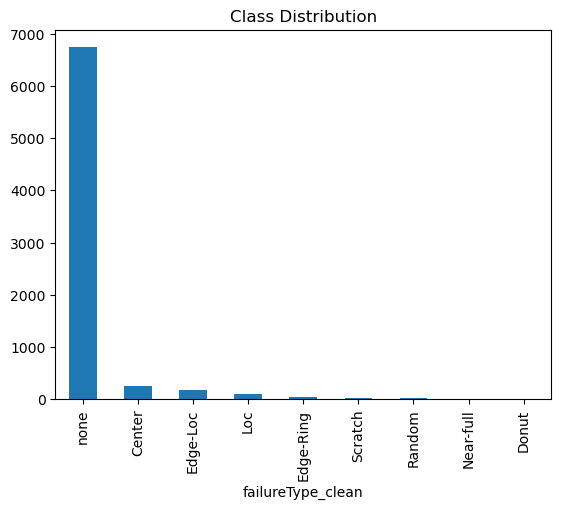

In [15]:
import matplotlib.pyplot as plt
df['failureType_clean'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()
